In [15]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from utils import make_compare_plot,plot_cdf,plot_pdf,convert_type,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


In [2]:
data = pd.read_csv("adult_train.csv")

# 5% sample of origin data
data_sample = pd.read_csv("adult_train_sample.csv")

# Origin GAN, no fds,no mean loss
origin_GAN = pd.read_csv("generated/strong/origin/sample_data_1_699_0.csv")

# marital-status -> relationship
its_MS = pd.read_csv("generated/strong/ITS/sample_data_1_699_0.csv")

# education-num * 500 = capital-gain
its_linear = pd.read_csv("results/its_sample.csv")

# education-num, age, hours-per-week -> income
its_complex = pd.read_csv("generated/complex/ITS/sample_data_1_699_0.csv")


baseline_VAE = pd.read_csv("../VAE/expdir/adult/sample_data_vae_699_0.csv")
baseline_VAE.columns = data.columns.tolist()


## Visualization

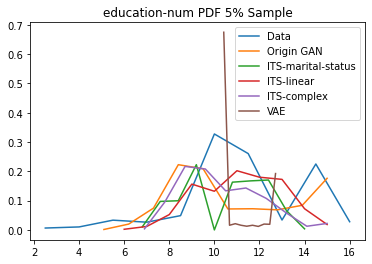

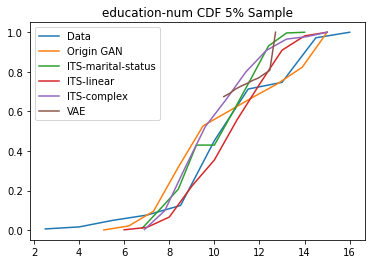

In [3]:
make_compare_plot([data,origin_GAN,its_MS,its_linear,its_complex,baseline_VAE],"education-num",plot_pdf,["Data","Origin GAN","ITS-marital-status","ITS-linear","ITS-complex","VAE"],"education-num PDF 5% Sample")
make_compare_plot([data,origin_GAN,its_MS,its_linear,its_complex,baseline_VAE],"education-num",plot_cdf,["Data","Origin GAN","ITS-marital-status","ITS-linear","ITS-complex","VAE"],"education-num CDF 5% Sample")

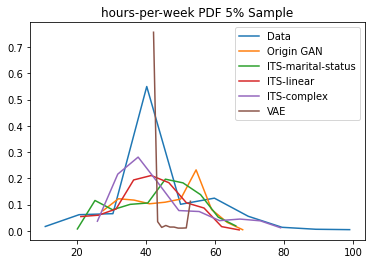

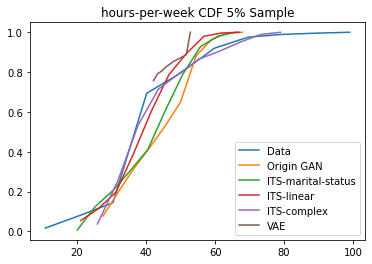

In [4]:
make_compare_plot([data,origin_GAN,its_MS,its_linear,its_complex,baseline_VAE],"hours-per-week",plot_pdf,["Data","Origin GAN","ITS-marital-status","ITS-linear","ITS-complex","VAE"],"hours-per-week PDF 5% Sample")
make_compare_plot([data,origin_GAN,its_MS,its_linear,its_complex,baseline_VAE],"hours-per-week",plot_cdf,["Data","Origin GAN","ITS-marital-status","ITS-linear","ITS-complex","VAE"],"hours-per-week CDF 5% Sample")

## Evaluation

In [5]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
2,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
3,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K


#### Convert data type

In [6]:
data["label"] = "data"
origin_GAN["label"]="origin"
its_MS["label"] = "its"
# fds["label"] = "fds"
# mean_loss["label"] = "mean_loss"
its_linear["label"] = "its_linear"
its_complex["label"] = "its_complex"
baseline_VAE["label"] = "VAE"
data_sample["label"] = "sample"

full = pd.concat([data,data_sample,origin_GAN, its_MS,its_linear,its_complex,baseline_VAE])
full[['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income']] = convert_type(full,['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income'])

data = full[full["label"] == "data"]
data_sample = full[full["label"] == "sample"]
origin_GAN = full[full["label"] == "origin"]
its = full[full["label"] == "its"]
its_weak = full[full["label"] == "its_linear"]
its_complex = full[full["label"] == "its_complex"]
baseline_VAE = full[full["label"] == "VAE"]

In [7]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,label
0,38.0,2,215646.0,11,9.0,0,5,1,4,1,0.0,0.0,40.0,37,0,data
1,53.0,2,234721.0,1,7.0,2,5,0,2,1,0.0,0.0,40.0,37,0,data
2,28.0,2,338409.0,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4,0,data
3,37.0,2,284582.0,12,14.0,2,3,5,4,0,0.0,0.0,40.0,37,0,data
4,31.0,2,45781.0,12,14.0,4,9,1,4,0,14084.0,0.0,50.0,37,1,data


#### Split train and test

In [8]:
origin_np = np.array(data)
col = list(data.columns)
indices = numpy.random.permutation(data.shape[0])
n = data.shape[0] - baseline_VAE.shape[0]
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)


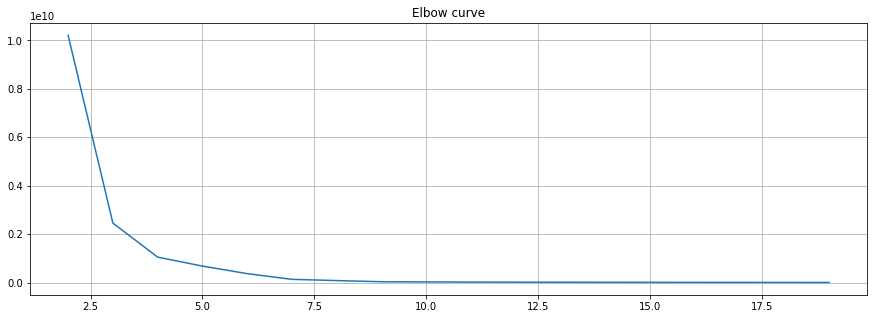

In [9]:
X = training_data.drop(columns=["label","fnlwgt"]).astype("float64")
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)

plt.title('Elbow curve')
plt.show()

In [10]:
dataset = [data_sample,origin_GAN, its,its_weak,its_complex,baseline_VAE]

In [11]:
prediction = {}
prediction["age"] = make_prediction("age", "reg",training_data, test,dataset)
prediction["workclass"] = make_prediction("workclass", "clf",training_data, test,dataset)
prediction["education"] = make_prediction("education", "clf",training_data, test,dataset)
prediction["education_num"] = make_prediction("education-num", "clf",training_data, test,dataset)
prediction["marital_status"] = make_prediction("marital-status", "clf",training_data, test,dataset)
prediction["occupation"] = make_prediction("occupation", "clf",training_data, test,dataset)
prediction["relationship"] = make_prediction("relationship", "clf",training_data, test,dataset)
prediction["race"] = make_prediction("race", "clf",training_data, test,dataset)
prediction["sex"] = make_prediction("sex", "clf",training_data, test,dataset)
prediction["capital_gain"] = make_prediction("capital-gain", "reg",training_data, test,dataset)
prediction["capital_loss"] = make_prediction("capital-loss", "reg",training_data, test,dataset)
prediction["hours_per_week"] = make_prediction("hours-per-week", "reg",training_data, test,dataset)
prediction["native_country"] = make_prediction("native-country", "clf",training_data, test,dataset)
prediction["income"] = make_prediction("income", "clf",training_data, test,dataset)

prediction_diff = {}
prediction_diff["age"] = make_prediction_diff("age", "reg",training_data, test,dataset)
prediction_diff["workclass"] = make_prediction_diff("workclass", "clf",training_data, test,dataset)
prediction_diff["education"] = make_prediction_diff("education", "clf",training_data, test,dataset)
prediction_diff["education_num"] = make_prediction_diff("education-num", "clf",training_data, test,dataset)
prediction_diff["marital_status"] = make_prediction_diff("marital-status", "clf",training_data, test,dataset)
prediction_diff["occupation"] = make_prediction_diff("occupation", "clf",training_data, test,dataset)
prediction_diff["relationship"] = make_prediction_diff("relationship", "clf",training_data, test,dataset)
prediction_diff["race"] = make_prediction_diff("race", "clf",training_data, test,dataset)
prediction_diff["sex"] = make_prediction_diff("sex", "clf",training_data, test,dataset)
prediction_diff["capital_gain"] = make_prediction_diff("capital-gain", "reg",training_data, test,dataset)
prediction_diff["capital_loss"] = make_prediction_diff("capital-loss", "reg",training_data, test,dataset)
prediction_diff["hours_per_week"] = make_prediction_diff("hours-per-week", "reg",training_data, test,dataset)
prediction_diff["native_country"] = make_prediction_diff("native-country", "clf",training_data, test,dataset)
prediction_diff["income"] = make_prediction_diff("income", "clf",training_data, test,dataset)

### Machine Learning utils

In [12]:
pd.DataFrame(prediction,index=["ground Truth","Sample 5%","Origin GAN","Marital-FD","Linear-FD","Complex-FD","VAE"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.291797,0.704445,1.000000,0.999302,0.823435,0.275619,0.756049,0.842324,0.826857,-0.418505,-0.366776,0.017251,0.910094,0.831535
Sample 5%,0.301336,0.718480,0.997731,0.999965,0.828742,0.307007,0.770015,0.864809,0.835481,-0.649198,-0.313458,0.052406,0.912678,0.839356
Origin GAN,0.043291,0.631228,0.433330,0.067875,0.677770,0.140009,0.617786,0.830558,0.697601,-9.313861,-1.608825,-0.239269,0.785133,0.742327
Marital-FD,0.017879,0.552774,0.389931,0.189972,0.688035,0.124716,0.561607,0.671415,0.711183,-9.484545,-2.064639,-0.210563,0.441395,0.809958
Linear-FD,-0.222890,0.536608,0.248734,0.045948,0.637617,0.146049,0.412590,0.699626,0.674767,-0.292944,-0.950525,-0.157423,0.789532,0.771551
Complex-FD,0.036078,0.633707,0.455222,0.183583,0.726057,0.175064,0.518837,0.716351,0.731399,-3.655400,-3.315326,-0.726889,0.729095,0.778185
VAE,-0.082914,NaN,0.479872,NaN,0.641982,0.266052,0.569463,NaN,0.738871,0.021502,-0.051345,-0.064359,NaN,0.795433


In [13]:
pd.DataFrame(prediction_diff,index=["ground Truth","Sample 5%","Origin GAN","Marital-FD","Linear-FD","Complex-FD","VAE"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sample 5%,0.009539,0.014036,0.002269,0.000663,0.005307,0.031389,0.013966,0.022485,0.008624,0.230694,0.053317,0.035156,0.002584,0.007821
Origin GAN,0.248505,0.073217,0.566670,0.931427,0.145665,0.135610,0.138263,0.011766,0.129255,8.895356,1.242050,0.256520,0.124961,0.089208
Marital-FD,0.273918,0.151671,0.610069,0.809329,0.135400,0.150903,0.194442,0.170909,0.115673,9.066040,1.697864,0.227814,0.468699,0.021577
Linear-FD,0.514687,0.167836,0.751266,0.953354,0.185818,0.129569,0.343459,0.142698,0.152090,0.125561,0.583750,0.174674,0.120561,0.059984
Complex-FD,0.255719,0.070738,0.544778,0.815719,0.097378,0.100555,0.237212,0.125973,0.095458,3.236895,2.948551,0.744140,0.180999,0.053350
VAE,0.374711,NaN,0.520128,NaN,0.181453,0.009567,0.186586,NaN,0.087986,0.440007,0.315431,0.081610,NaN,0.036102


### Clustering

In [16]:
from sklearn.cluster import KMeans
pd.DataFrame(make_clustering(training_data,test,dataset),index=["ground Truth","Sample 5%","Origin GAN","Marital-FD","Linear-FD","Complex-FD","VAE"],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
Sample 5%,0.847277
Origin GAN,0.485732
Marital-FD,0.481838
Linear-FD,0.708619
Complex-FD,0.695915
VAE,0.678684


### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [17]:
similar = hitting_rate(dataset)

500it [00:31, 15.71it/s]
500it [00:31, 15.71it/s]
500it [00:31, 15.68it/s]
500it [00:32, 15.51it/s]
500it [00:32, 15.39it/s]


In [18]:
maxi,mini = DCR(dataset)

In [20]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Marital-FD","Linear-FD","Complex-FD","VAE"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])

,Exactly Same data (Categorical),Distance to the furthest record,Distance to the closest record
Origin GAN,28.0,2.567465,0.065726
Marital-FD,21.0,2.684291,0.061005
Linear-FD,22.0,2.513696,0.035174
Complex-FD,16.0,2.557805,0.090680
VAE,0.0,2.276016,0.042216
